Представимо початкові дані графiчно, розіб'ємо їх на навчальний та валiдацiйний набори:

Перші рядки датасету:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


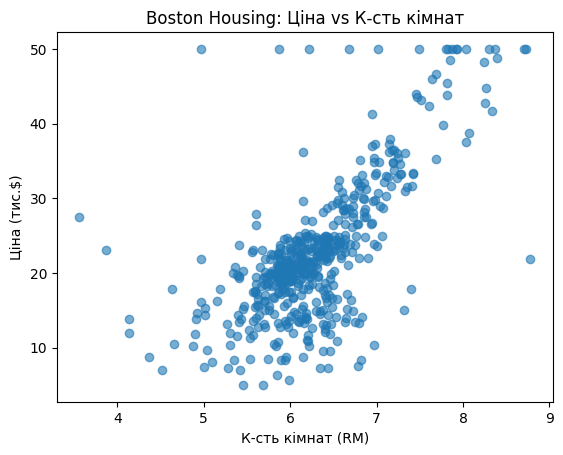

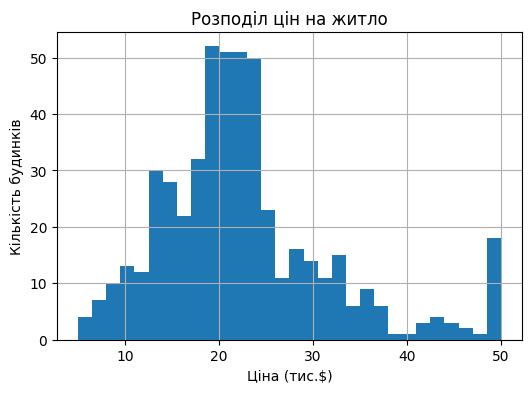

Розмір Train: (404, 13)
Розмір Validation: (102, 13)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
df = pd.DataFrame(data, columns=columns)
df["PRICE"] = target

print("Перші рядки датасету:")
print(df.head())

plt.scatter(df["RM"], df["PRICE"], alpha=0.6)
plt.xlabel("К-сть кімнат (RM)")
plt.ylabel("Ціна (тис.$)")
plt.title("Boston Housing: Ціна vs К-сть кімнат")
plt.show()

df["PRICE"].hist(bins=30, figsize=(6,4))
plt.xlabel("Ціна (тис.$)")
plt.ylabel("Кількість будинків")
plt.title("Розподіл цін на житло")
plt.show()

X = df.drop("PRICE", axis=1)
y = df["PRICE"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Розмір Train:", X_train.shape)
print("Розмір Validation:", X_val.shape)

Побудуємо модель лінійної регресії з fit_intercept:

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Представимо модель графічно та виконаємо прогнози на її основі:

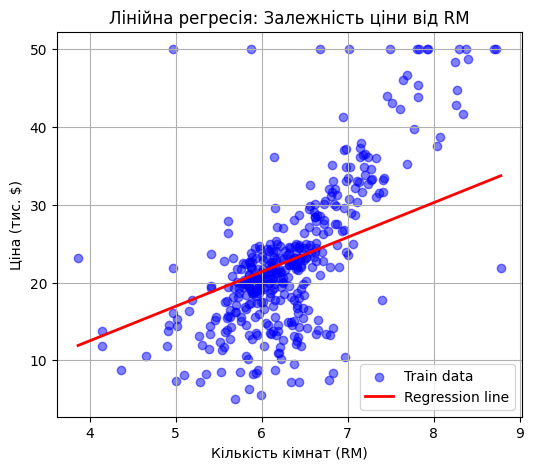

In [3]:
plt.figure(figsize=(6, 5))
plt.scatter(X_train["RM"], y_train, color="blue", alpha=0.5, label="Train data")

rm_values = np.linspace(X_train["RM"].min(), X_train["RM"].max(), 100)
base_row = X_train.mean().to_frame().T

pred_lines = []
for rm in rm_values:
    row = base_row.copy()
    row["RM"] = rm
    row = row[X_train.columns]
    pred = model.predict(row)[0]
    pred_lines.append(pred)

plt.plot(rm_values, pred_lines, color="red", linewidth=2, label="Regression line")
plt.xlabel("Кількість кімнат (RM)")
plt.ylabel("Ціна (тис. $)")
plt.title("Лінійна регресія: Залежність ціни від RM")
plt.legend()
plt.grid(True)
plt.show()

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

Обчислимо метрики R2, RMSE, MAE, MAPE для train і validation:

In [4]:
def regression_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n {dataset_name} ")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE:  {mae:.3f}")
    print(f"MAPE: {mape:.2f}%")

regression_metrics(y_train, y_train_pred, "Train")
regression_metrics(y_val, y_val_pred, "Validation")


 Train 
R²:   0.751
RMSE: 4.652
MAE:  3.315
MAPE: 16.57%

 Validation 
R²:   0.669
RMSE: 4.929
MAE:  3.189
MAPE: 16.87%


Перевіримо модель на перенавчання 

In [6]:
print("\nПеревірка перенавчання:")
if r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred) > 0.1:
    print(" Модель може бути перенавчена (велика різниця між Train і Validation).")
else:
    print(" Перенавчання не спостерігається.")




Перевірка перенавчання:
 Перенавчання не спостерігається.


Виконаємо решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей:

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
    "fit_intercept": [True, False],
    "positive": [False, True]
}
gs = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    return_train_score=True,
    n_jobs=-1
)
gs.fit(X_train, y_train)

print("\n Grid Search (LinearRegression) ")
print("Best params:", gs.best_params_)
print("Best CV RMSE:", np.sqrt(-gs.best_score_))

best_lr = gs.best_estimator_
y_val_pred_gs = best_lr.predict(X_val)
print("Validation RMSE (best LR):", np.sqrt(mean_squared_error(y_val, y_val_pred_gs)))
print("Validation R^2  (best LR):", r2_score(y_val, y_val_pred_gs))

cv_res = pd.DataFrame(gs.cv_results_)
cv_res["mean_test_RMSE"] = np.sqrt(-cv_res["mean_test_score"])
cv_res["mean_train_RMSE"] = np.sqrt(-cv_res["mean_train_score"])
print("\nCV results (RMSE):")
print(cv_res[["params","mean_train_RMSE","mean_test_RMSE","std_test_score"]]
      .sort_values("mean_test_RMSE").to_string(index=False))


 Grid Search (LinearRegression) 
Best params: {'fit_intercept': True, 'positive': False}
Best CV RMSE: 4.863580807420046
Validation RMSE (best LR): 4.928602182665339
Validation R^2  (best LR): 0.6687594935356317

CV results (RMSE):
                                     params  mean_train_RMSE  mean_test_RMSE  std_test_score
 {'fit_intercept': True, 'positive': False}         4.628581        4.863581        5.825322
{'fit_intercept': False, 'positive': False}         4.792272        5.051275        7.380798
  {'fit_intercept': True, 'positive': True}         5.940368        6.071758       12.499886
 {'fit_intercept': False, 'positive': True}         7.235903        7.268678        7.237847


Визначимо найкращу модель та проаналізуємо вплив розміру навчальної множини на помилку


 Порівняння моделей на Validation 
Базова LR (наша): {'RMSE': np.float64(4.928602182665339), 'MAE': 3.1890919658878416, 'R2': 0.6687594935356317}
Найкраща LR (GridSearchCV): {'RMSE': np.float64(4.928602182665339), 'MAE': 3.1890919658878416, 'R2': 0.6687594935356317}

Висновок: краща за RMSE модель — Baseline. Різниця RMSE = 0.000.


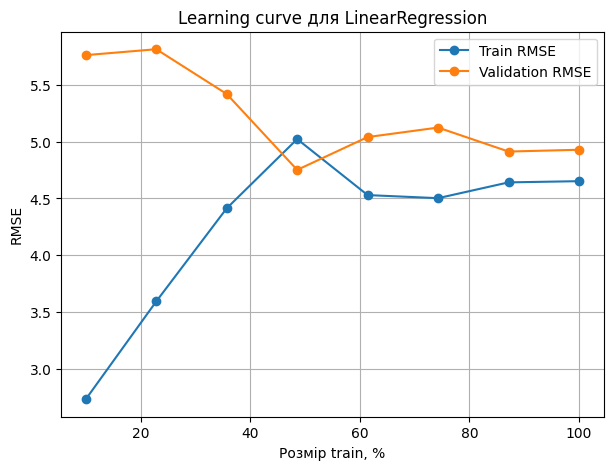


 Learning curve (таблиця) 
 train_percent  RMSE_train  RMSE_val
            10       2.732     5.762
            23       3.593     5.814
            36       4.413     5.420
            49       5.023     4.751
            61       4.529     5.040
            74       4.502     5.124
            87       4.641     4.913
           100       4.652     4.929


In [8]:
from sklearn.metrics import mean_absolute_error

def metrics_pack(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

base_val = metrics_pack(y_val, model.predict(X_val))
gs_val   = metrics_pack(y_val, best_lr.predict(X_val))

print("\n Порівняння моделей на Validation ")
print("Базова LR (наша):", base_val)
print("Найкраща LR (GridSearchCV):", gs_val)

chosen = "GridSearchCV" if gs_val["RMSE"] < base_val["RMSE"] else "Baseline"
print(f"\nВисновок: краща за RMSE модель — {chosen}. "
      f"Різниця RMSE = {abs(gs_val['RMSE'] - base_val['RMSE']):.3f}.")

import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
train_fracs = np.linspace(0.1, 1.0, 8)

rmse_train, rmse_val = [], []

for frac in train_fracs:
    n_sub = max(5, int(len(X_train) * frac))
    idx = rng.choice(len(X_train), size=n_sub, replace=False)
    X_sub = X_train.iloc[idx]
    y_sub = y_train.iloc[idx]

    m = LinearRegression(fit_intercept=True)
    m.fit(X_sub, y_sub)

    rmse_train.append(np.sqrt(mean_squared_error(y_sub, m.predict(X_sub))))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, m.predict(X_val))))

plt.figure(figsize=(7, 5))
plt.plot(train_fracs * 100, rmse_train, marker='o', label='Train RMSE')
plt.plot(train_fracs * 100, rmse_val, marker='o', label='Validation RMSE')
plt.xlabel("Розмір train, %")
plt.ylabel("RMSE")
plt.title("Learning curve для LinearRegression")
plt.grid(True)
plt.legend()
plt.show()

lc_table = pd.DataFrame({
    "train_percent": (train_fracs * 100).round(0).astype(int),
    "RMSE_train": np.round(rmse_train, 3),
    "RMSE_val":   np.round(rmse_val, 3)
})
print("\n Learning curve (таблиця) ")
print(lc_table.to_string(index=False))


Висновок: лінійна регресія показала стабільну якість без ознак перенавчання. Пошук гіперпараметрів майже не покращив результатів, тож базова модель ефективна для цих даних. Використання більшої навчальної вибірки покращує узагальнюючу здатність моделі та зменшує ризик перенавчання, забезпечуючи стабільну якість прогнозу